<a href="https://colab.research.google.com/github/MiracleCakra/Machine-Learning_Ganjil_2025/blob/main/Week08_JS08/UTS_MACHINE_LEARNING_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ujian Tengah Semester Machine Learning — Credit Card Dataset (Clustering & ANN)

## Nama  : Cakra Wangsa May Ahmad Widodo
## Kelas : TI-3G/08
## NIM   : 2341720032

Notebook ini digunakan sebagai **Ujian Tengah Semester Machine Learning — Credit Card Dataset**:
1) **Preprocessing** (missing values, normalisasi/standarisasi, fitur baru)
2) **Clustering** dengan **KMeans** dan **DBSCAN** + evaluasi **Silhouette** & **Davies–Bouldin Index (DBI)**
3) **Approximate Nearest Neighbor (ANN)** untuk mengecek konsistensi tetangga terdekat terhadap klasternya (gunakan **Annoy** jika tersedia; fallback ke `NearestNeighbors` jika Annoy tidak terpasang).
4) **Visualisasi Tambahan** untuk mendalami struktur data dan hasil klaster.



In [32]:
# === 1) Imports
!pip install annoy

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Optional Annoy (ANN). If not available, we will fallback to NearestNeighbors.
try:
    from annoy import AnnoyIndex
    _ANNOY_OK = True
except Exception:
    _ANNOY_OK = False
    print("Annoy tidak tersedia di lingkungan ini. Akan fallback ke NearestNeighbors.")


## 2) Load Dataset & Inspeksi Singkat

In [4]:
# Path to UCI Credit Card dataset
CSV_PATH = '/content/UCI_Credit_Card.csv'
# Baca dataset
import pandas as pd
assert CSV_PATH is not None
assert pd.read_csv
# read
import os
assert os.path.exists(CSV_PATH), f'File tidak ditemukan: {CSV_PATH}'
df = pd.read_csv(CSV_PATH)
# Tampilkan beberapa baris awal dan informasi dataset
display(df.head())
print("Dimensi:", df.shape)
print("Info:")
print(df.info())
print("Deskripsi numerik:")
display(df.describe(include='all').T)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,2,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,3,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,4,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,5,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0


Dimensi: (22041, 25)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22041 entries, 0 to 22040
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          22041 non-null  int64  
 1   LIMIT_BAL                   22041 non-null  float64
 2   SEX                         22040 non-null  float64
 3   EDUCATION                   22040 non-null  float64
 4   MARRIAGE                    22040 non-null  float64
 5   AGE                         22040 non-null  float64
 6   PAY_0                       22040 non-null  float64
 7   PAY_2                       22040 non-null  float64
 8   PAY_3                       22040 non-null  float64
 9   PAY_4                       22040 non-null  float64
 10  PAY_5                       22040 non-null  float64
 11  PAY_6                       22040 non-null  float64
 12  BILL_AMT1                   22040 non-null  float64
 13  BILL

,count,mean,std,min,25%,50%,75%,max
ID,22041.0,11021.000000,6362.832978,1.0,5511.00,11021.0,16531.00,22041.0
LIMIT_BAL,22041.0,162927.892564,128591.879082,10000.0,50000.00,130000.0,230000.00,1000000.0
SEX,22040.0,1.602042,0.489488,1.0,1.00,2.0,2.00,2.0
EDUCATION,22040.0,1.841742,0.775434,0.0,1.00,2.0,2.00,6.0
MARRIAGE,22040.0,1.561933,0.521573,0.0,1.00,2.0,2.00,3.0
AGE,22040.0,35.309574,9.351772,21.0,28.00,34.0,41.00,79.0
PAY_0,22040.0,0.019419,1.121497,-2.0,-1.00,0.0,0.00,8.0
PAY_2,22040.0,-0.103312,1.199501,-2.0,-1.00,0.0,0.00,8.0
PAY_3,22040.0,-0.134437,1.204877,-2.0,-1.00,0.0,0.00,8.0
PAY_4,22040.0,-0.194283,1.166055,-2.0,-1.00,0.0,0.00,8.0


## 3) Preprocessing
- Tangani **missing values** dengan *median* (fitur numerik).
- Buat **fitur baru**: `BALANCE_TO_PURCHASES`, `BALANCE_TO_LIMIT`, `PURCHASES_PER_MONTH`.
- **Standarisasi** semua fitur numerik (kecuali `CUST_ID`).


In [9]:
# === Preprocessing & Feature Engineering untuk dataset UCI Credit Card ===
# Gunakan kolom 'ID' sebagai identifikasi
id_col = 'ID'
assert id_col in df.columns, "Kolom ID tidak ada di dataset"

# Salin fitur numerik (drop ID)
num_df = df.drop(columns=[id_col]).copy()

# Tangani missing values dengan median
num_df = num_df.fillna(num_df.median(numeric_only=True))

# Fitur tambahan khusus UCI:
bill_cols = [f'BILL_AMT{i}' for i in range(1,7)]
pay_cols = [f'PAY_AMT{i}' for i in range(1,7)]

# Sum & mean tagihan 6 bulan
num_df['BILL_SUM_6M'] = df[bill_cols].sum(axis=1)
num_df['BILL_MEAN_6M'] = df[bill_cols].mean(axis=1)

# Sum & mean pembayaran 6 bulan
num_df['PAY_SUM_6M'] = df[pay_cols].sum(axis=1)
num_df['PAY_MEAN_6M'] = df[pay_cols].mean(axis=1)

# Rasio pembayaran terhadap tagihan total
num_df['PAYMENT_RATE'] = num_df['PAY_SUM_6M'] / (num_df['BILL_SUM_6M'] + 1e-9)

# Utilization rata-rata: rata-rata tagihan dibanding LIMIT_BAL
num_df['UTILIZATION_MEAN'] = num_df['BILL_MEAN_6M'] / (df['LIMIT_BAL'] + 1e-9)

# Jumlah bulan telat dan keterlambatan maksimum
num_df['DELAY_COUNT_6M'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].gt(0).sum(axis=1)
num_df['MAX_DELAY'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].max(axis=1)

# Variabilitas pembayaran per bulan
num_df['PAYMENT_VARIABILITY'] = df[pay_cols].std(axis=1)

# Rasio total tagihan vs total pembayaran (proxy balance/purchases)
num_df['BALANCE_PURCHASE_RATIO'] = num_df['BILL_SUM_6M'] / (num_df['PAY_SUM_6M'] + 1e-9)

# Ensure all remaining NaNs are handled before standardization
num_df = num_df.fillna(num_df.median(numeric_only=True))


# Standarisasi
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(num_df.values)
print("Bentuk dataset setelah normalisasi:", X.shape)

Bentuk dataset setelah normalisasi: (22041, 34)


## 4) Clustering — KMeans (pilih *k* terbaik via Silhouette)

## 4a) Elbow Method untuk Menentukan K Optimal

Menghitung metrik untuk berbagai nilai k...


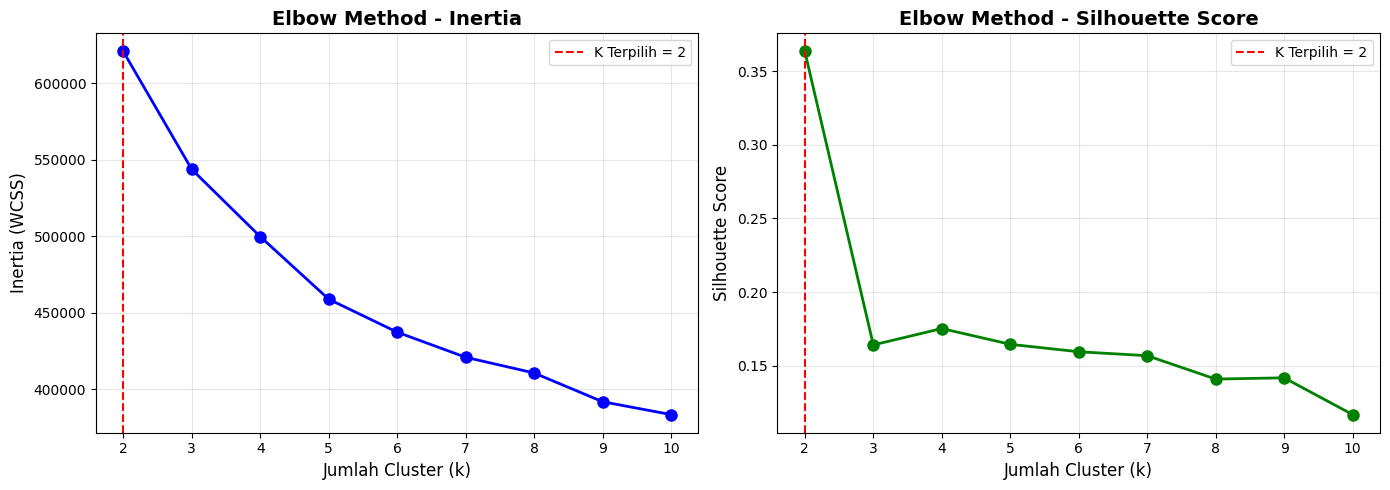


📊 Analisis Elbow Method:
   K optimal (berdasarkan Silhouette): 2
   Silhouette Score: 0.3634
   DBI Score: 1.5826
   Inertia pada k=2: 620826.38


In [10]:
# Elbow Method: Plot inertia (WCSS - Within-Cluster Sum of Squares) untuk berbagai nilai k
k_range = range(2, 11)
inertias = []
silhouettes = []
dbis = []

print("Menghitung metrik untuk berbagai nilai k...")
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)
    if len(set(km.labels_)) > 1:
        sil = silhouette_score(X, km.labels_)
        dbi = davies_bouldin_score(X, km.labels_)
        silhouettes.append(sil)
        dbis.append(dbi)
    else:
        silhouettes.append(0)
        dbis.append(float('inf'))

# Tentukan k optimal berdasarkan silhouette score tertinggi
best_k_idx = silhouettes.index(max(silhouettes))
best_k = list(k_range)[best_k_idx]

# Plot Elbow Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Inertia (WCSS)
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Jumlah Cluster (k)', fontsize=12)
ax1.set_ylabel('Inertia (WCSS)', fontsize=12)
ax1.set_title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=best_k, color='red', linestyle='--', label=f"K Terpilih = {best_k}")
ax1.legend()

# Plot 2: Silhouette Score
ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Jumlah Cluster (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Elbow Method - Silhouette Score', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=best_k, color='red', linestyle='--', label=f"K Terpilih = {best_k}")
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Analisis Elbow Method:")
print(f"   K optimal (berdasarkan Silhouette): {best_k}")
print(f"   Silhouette Score: {silhouettes[best_k_idx]:.4f}")
print(f"   DBI Score: {dbis[best_k_idx]:.4f}")
print(f"   Inertia pada k={best_k}: {inertias[best_k_idx]:.2f}")

In [11]:
def kmeans_best_k(X, k_min=2, k_max=10, random_state=42):
    best = None
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(X)
        if len(set(labels)) > 1:
            sil = silhouette_score(X, labels)
            dbi = davies_bouldin_score(X, labels)
        else:
            sil, dbi = float('nan'), float('inf')
        if best is None or (not math.isnan(sil) and sil > best['silhouette']):
            best = {'k': k, 'model': km, 'labels': labels, 'silhouette': sil, 'dbi': dbi}
    return best

best_kmeans = kmeans_best_k(X, k_min=2, k_max=10)
print("Best K for KMeans:", best_kmeans['k'])
print("Silhouette:", best_kmeans['silhouette'])
print("DBI:", best_kmeans['dbi'])


Best K for KMeans: 2
Silhouette: 0.3634109151193419
DBI: 1.5826111353180643


## 5) Clustering — DBSCAN (grid kecil eps × min_samples)

In [12]:
def dbscan_grid_search(X, eps_list=(0.5,1.0,1.5,2.0,2.5,3.0), min_samples_list=(3,5,10)):
    candidates = []
    for eps in eps_list:
        for ms in min_samples_list:
            db = DBSCAN(eps=eps, min_samples=ms)
            labels = db.fit_predict(X)
            uniq = set(labels)
            # valid jika >=2 klaster berbeda selain noise
            if len(uniq) > 1 and sum(l != -1 for l in labels) > 1 and len(set([l for l in labels if l != -1])) >= 1:
                try:
                    sil = silhouette_score(X, labels)
                except Exception:
                    sil = float('nan')
                try:
                    dbi = davies_bouldin_score(X, labels)
                except Exception:
                    dbi = float('inf')
            else:
                sil, dbi = float('nan'), float('inf')
            candidates.append({'eps': eps, 'min_samples': ms, 'labels': labels, 'silhouette': sil, 'dbi': dbi})
    candidates = [c for c in candidates if not math.isnan(c['silhouette'])]
    if not candidates:
        return None
    candidates.sort(key=lambda c: (-c['silhouette'], c['dbi']))
    return candidates[0]

best_dbscan = dbscan_grid_search(X)
if best_dbscan is None:
    print("Tidak ada konfigurasi DBSCAN valid pada grid. Coba perluas parameter.")
else:
    labels_db = best_dbscan['labels']
    print("Best DBSCAN -> eps=", best_dbscan['eps'], "min_samples=", best_dbscan['min_samples'])
    print("Silhouette:", best_dbscan['silhouette'])
    print("DBI:", best_dbscan['dbi'])
    import collections
    print("Distribusi label:", collections.Counter(labels_db))


Best DBSCAN -> eps= 3.0 min_samples= 10
Silhouette: 0.4202828550897971
DBI: 1.723611388274762
Distribusi label: Counter({np.int64(0): 20228, np.int64(-1): 1774, np.int64(1): 23, np.int64(2): 16})


## 5a) Labeling Cluster dan Analisis Noise

📋 LABELING CLUSTER DAN ANALISIS NOISE

🔵 KMeans Clustering:
----------------------------------------------------------------------
   Jumlah Cluster: 2
   Total Data Points: 22041
   
   Distribusi per Cluster:
      Cluster 0: 3416 data points (15.50%)
      Cluster 1: 18625 data points (84.50%)


🔴 DBSCAN Clustering:
----------------------------------------------------------------------
   Jumlah Cluster: 3
   Total Data Points: 22041
   🔊 Noise Points: 1774 (8.05%)
   
   Distribusi per Cluster:
      ⚠️  Noise (-1): 1774 data points (8.05%)
      Cluster 0: 20228 data points (91.77%)
      Cluster 1: 23 data points (0.10%)
      Cluster 2: 16 data points (0.07%)


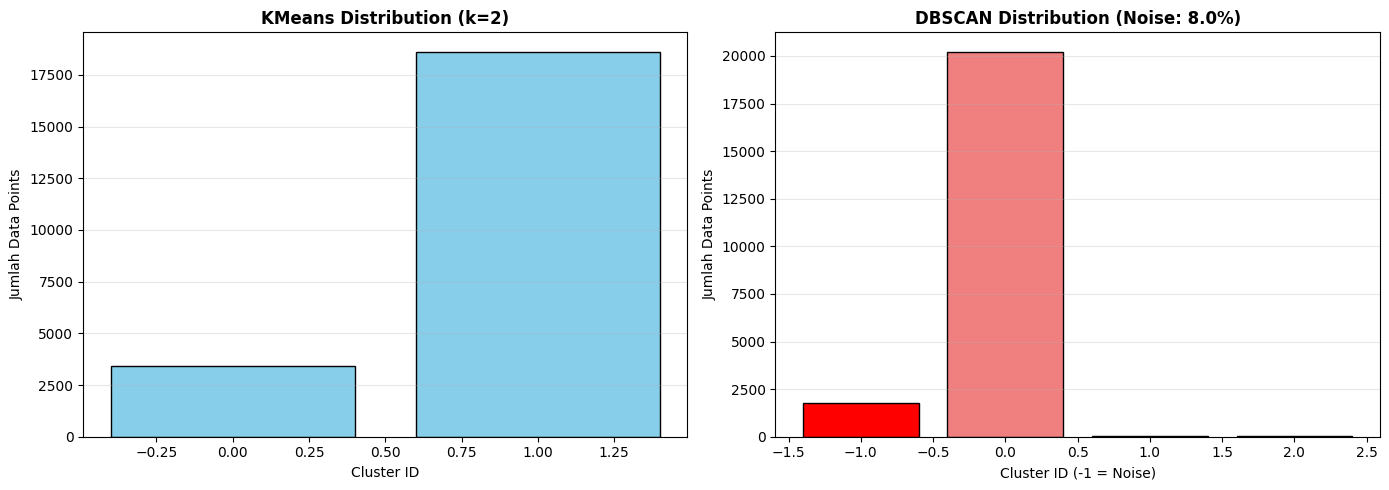



📊 Summary Table:
----------------------------------------------------------------------


,Method,Clusters,Noise Points,Noise %,Silhouette,DBI
0,KMeans,2,0,0,0.3634,1.5826
1,DBSCAN,3,1774,8.05,0.4203,1.7236


In [13]:
# === Labeling dan Analisis Cluster ===
import pandas as pd
from collections import Counter

print("="*70)
print("📋 LABELING CLUSTER DAN ANALISIS NOISE")
print("="*70)

# 1) Analisis KMeans
print("\n🔵 KMeans Clustering:")
print("-" * 70)
km_labels = best_kmeans['labels']
km_counter = Counter(km_labels)
print(f"   Jumlah Cluster: {best_kmeans['k']}")
print(f"   Total Data Points: {len(km_labels)}")
print(f"   \n   Distribusi per Cluster:")
for cluster_id in sorted(km_counter.keys()):
    count = km_counter[cluster_id]
    percentage = (count / len(km_labels)) * 100
    print(f"      Cluster {cluster_id}: {count} data points ({percentage:.2f}%)")

# Tambahkan label ke dataframe
df_kmeans = df.copy()
df_kmeans['Cluster_KMeans'] = km_labels

# 2) Analisis DBSCAN (jika valid)
if best_dbscan is not None:
    print("\n\n🔴 DBSCAN Clustering:")
    print("-" * 70)
    db_labels = best_dbscan['labels']
    db_counter = Counter(db_labels)

    # Hitung noise
    noise_count = sum(1 for label in db_labels if label == -1)
    noise_percentage = (noise_count / len(db_labels)) * 100

    # Hitung jumlah cluster (tidak termasuk noise)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

    print(f"   Jumlah Cluster: {n_clusters}")
    print(f"   Total Data Points: {len(db_labels)}")
    print(f"   🔊 Noise Points: {noise_count} ({noise_percentage:.2f}%)")
    print(f"   \n   Distribusi per Cluster:")

    for cluster_id in sorted(db_counter.keys()):
        count = db_counter[cluster_id]
        percentage = (count / len(db_labels)) * 100
        if cluster_id == -1:
            print(f"      ⚠️  Noise (-1): {count} data points ({percentage:.2f}%)")
        else:
            print(f"      Cluster {cluster_id}: {count} data points ({percentage:.2f}%)")

    # Tambahkan label ke dataframe
    df_dbscan = df.copy()
    df_dbscan['Cluster_DBSCAN'] = db_labels

    # Visualisasi perbandingan
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # KMeans distribution
    km_counts = pd.Series(km_labels).value_counts().sort_index()
    ax1.bar(km_counts.index, km_counts.values, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Jumlah Data Points')
    ax1.set_title(f'KMeans Distribution (k={best_kmeans["k"]})', fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    # DBSCAN distribution
    db_counts = pd.Series(db_labels).value_counts().sort_index()
    colors = ['red' if x == -1 else 'lightcoral' for x in db_counts.index]
    ax2.bar(db_counts.index, db_counts.values, color=colors, edgecolor='black')
    ax2.set_xlabel('Cluster ID (-1 = Noise)')
    ax2.set_ylabel('Jumlah Data Points')
    ax2.set_title(f'DBSCAN Distribution (Noise: {noise_percentage:.1f}%)', fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n\n📊 Summary Table:")
    print("-" * 70)
    summary_data = {
        'Method': ['KMeans', 'DBSCAN'],
        'Clusters': [best_kmeans['k'], n_clusters],
        'Noise Points': [0, noise_count],
        'Noise %': [0, f"{noise_percentage:.2f}"],
        'Silhouette': [f"{best_kmeans['silhouette']:.4f}",
                       f"{best_dbscan['silhouette']:.4f}" if best_dbscan else 'N/A'],
        'DBI': [f"{best_kmeans['dbi']:.4f}",
                f"{best_dbscan['dbi']:.4f}" if best_dbscan else 'N/A']
    }
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
else:
    print("\n⚠️  DBSCAN tidak menghasilkan clustering yang valid.")

    # Hanya visualisasi KMeans
    fig, ax = plt.subplots(figsize=(8, 5))
    km_counts = pd.Series(km_labels).value_counts().sort_index()
    ax.bar(km_counts.index, km_counts.values, color='skyblue', edgecolor='black')
    ax.set_xlabel('Cluster ID')
    ax.set_ylabel('Jumlah Data Points')
    ax.set_title(f'KMeans Distribution (k={best_kmeans["k"]})', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)

## 6) Visualisasi 2D (PCA) — KMeans vs DBSCAN

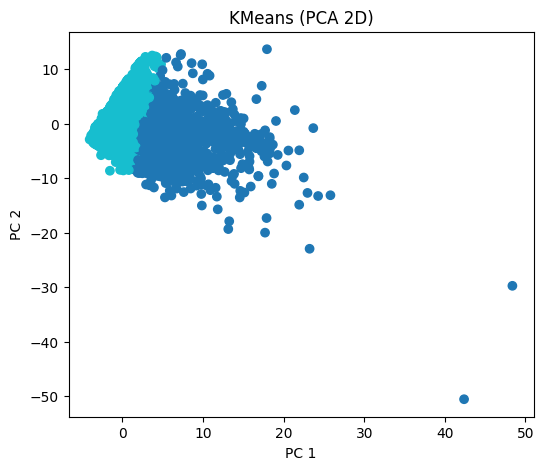

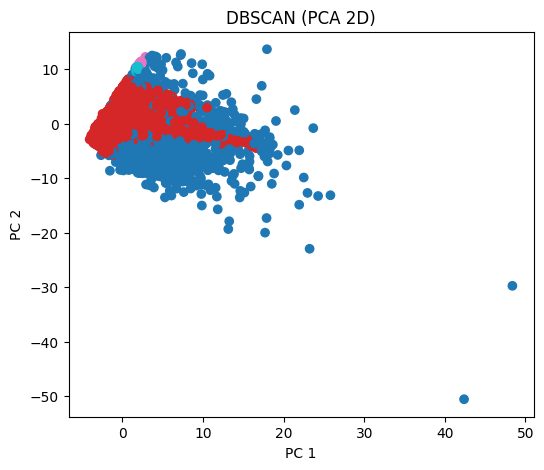

In [14]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=best_kmeans['labels'], cmap='tab10')
plt.title("KMeans (PCA 2D)")
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.show()

if best_dbscan is not None:
    plt.figure(figsize=(6,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=best_dbscan['labels'], cmap='tab10')
    plt.title("DBSCAN (PCA 2D)")
    plt.xlabel("PC 1"); plt.ylabel("PC 2")
    plt.show()


In [30]:
# === Profil Klaster Berdasarkan Median Fitur Penting ===
import numpy as np, pandas as pd

print("="*70)
print("👤 PROFIL PELANGGAN PER KLASTER")
print("="*70)

# Ensure num_df and clustering results are available
if 'num_df' not in globals():
    print("Error: num_df (preprocessed data) not found. Please run preprocessing steps.")
elif 'best_kmeans' not in globals():
    print("Error: KMeans results (best_kmeans) not found. Please run KMeans clustering.")
else:
    # Combine original data with cluster labels
    df_clustered = num_df.copy()
    df_clustered['Cluster_KMeans'] = best_kmeans['labels']

    use_dbscan_analysis = (best_dbscan is not None and len(set(best_dbscan['labels'])) > 1)
    if use_dbscan_analysis:
        df_clustered['Cluster_DBSCAN'] = best_dbscan['labels']

    # Define important features for profiling
    important_features = [
        'LIMIT_BAL', 'AGE', 'BILL_SUM_6M', 'PAY_SUM_6M', 'PAYMENT_RATE',
        'UTILIZATION_MEAN', 'DELAY_COUNT_6M', 'PAYMENT_VARIABILITY',
        'BALANCE_PURCHASE_RATIO'
    ]
    # Ensure features exist in the dataframe
    important_features = [f for f in important_features if f in df_clustered.columns]


    # --- Profiling KMeans Clusters ---
    print("\n🔵 KMeans Cluster Profiles:")
    print("-" * 70)
    for cluster_id in sorted(df_clustered['Cluster_KMeans'].unique()):
        cluster_data = df_clustered[df_clustered['Cluster_KMeans'] == cluster_id]
        median_profile = cluster_data[important_features].median().to_dict()
        n_members = len(cluster_data)

        description_tags = []
        # Example interpretations based on median values (thresholds are illustrative)
        if 'LIMIT_BAL' in median_profile and median_profile['LIMIT_BAL'] > num_df['LIMIT_BAL'].median():
            description_tags.append('Limit Kredit Tinggi')
        else:
             description_tags.append('Limit Kredit Rendah/Sedang')

        if 'UTILIZATION_MEAN' in median_profile and median_profile['UTILIZATION_MEAN'] > num_df['UTILIZATION_MEAN'].median():
             description_tags.append('Utilisasi Kredit Tinggi')
        else:
             description_tags.append('Utilisasi Kredit Rendah/Sedang')

        if 'DELAY_COUNT_6M' in median_profile and median_profile['DELAY_COUNT_6M'] > 0:
             description_tags.append('Ada Riwayat Keterlambatan')
        else:
             description_tags.append('Tidak Ada Riwayat Keterlambatan')

        if 'PAYMENT_RATE' in median_profile and median_profile['PAYMENT_RATE'] > num_df['PAYMENT_RATE'].median():
            description_tags.append('Tingkat Pembayaran Relatif Tinggi')
        else:
             description_tags.append('Tingkat Pembayaran Relatif Rendah')

        print(f"  Klaster {cluster_id} (n={n_members}): {' | '.join(description_tags)}")
        for feat in important_features:
             print(f"    - {feat}: {median_profile.get(feat, 'N/A'):.3f}")


    # --- Profiling DBSCAN Clusters (if valid) ---
    if use_dbscan_analysis:
        print("\n\n🔴 DBSCAN Cluster Profiles:")
        print("-" * 70)
        for cluster_id in sorted(df_clustered['Cluster_DBSCAN'].unique()):
            if cluster_id == -1:
                n_members = len(df_clustered[df_clustered['Cluster_DBSCAN'] == cluster_id])
                print(f"  ⚠️  Noise (-1): {n_members} data points (Outliers/Noise, tidak diprofiling secara rinci)")
                continue

            cluster_data = df_clustered[df_clustered['Cluster_DBSCAN'] == cluster_id]
            median_profile = cluster_data[important_features].median().to_dict()
            n_members = len(cluster_data)

            description_tags = []
            # Example interpretations based on median values (thresholds are illustrative)
            if 'LIMIT_BAL' in median_profile and median_profile['LIMIT_BAL'] > num_df['LIMIT_BAL'].median():
                description_tags.append('Limit Kredit Tinggi')
            else:
                 description_tags.append('Limit Kredit Rendah/Sedang')

            if 'UTILIZATION_MEAN' in median_profile and median_profile['UTILIZATION_MEAN'] > num_df['UTILIZATION_MEAN'].median():
                 description_tags.append('Utilisasi Kredit Tinggi')
            else:
                 description_tags.append('Utilisasi Kredit Rendah/Sedang')

            if 'DELAY_COUNT_6M' in median_profile and median_profile['DELAY_COUNT_6M'] > 0:
                 description_tags.append('Ada Riwayat Keterlambatan')
            else:
                 description_tags.append('Tidak Ada Riwayat Keterlambatan')

            if 'PAYMENT_RATE' in median_profile and median_profile['PAYMENT_RATE'] > num_df['PAYMENT_RATE'].median():
                description_tags.append('Tingkat Pembayaran Relatif Tinggi')
            else:
                 description_tags.append('Tingkat Pembayaran Relatif Rendah')


            print(f"  Klaster {cluster_id} (n={n_members}): {' | '.join(description_tags)}")
            for feat in important_features:
                print(f"    - {feat}: {median_profile.get(feat, 'N/A'):.3f}")


print("\n" + "="*70)

👤 PROFIL PELANGGAN PER KLASTER

🔵 KMeans Cluster Profiles:
----------------------------------------------------------------------
  Klaster 0 (n=3416): Limit Kredit Tinggi | Utilisasi Kredit Tinggi | Tidak Ada Riwayat Keterlambatan | Tingkat Pembayaran Relatif Rendah
    - LIMIT_BAL: 230000.000
    - AGE: 35.000
    - BILL_SUM_6M: 831284.500
    - PAY_SUM_6M: 43247.000
    - PAYMENT_RATE: 0.042
    - UTILIZATION_MEAN: 0.720
    - DELAY_COUNT_6M: 0.000
    - PAYMENT_VARIABILITY: 3144.721
    - BALANCE_PURCHASE_RATIO: 24.009
  Klaster 1 (n=18625): Limit Kredit Rendah/Sedang | Utilisasi Kredit Rendah/Sedang | Tidak Ada Riwayat Keterlambatan | Tingkat Pembayaran Relatif Tinggi
    - LIMIT_BAL: 100000.000
    - AGE: 33.000
    - BILL_SUM_6M: 94370.000
    - PAY_SUM_6M: 10926.000
    - PAYMENT_RATE: 0.106
    - UTILIZATION_MEAN: 0.182
    - DELAY_COUNT_6M: 0.000
    - PAYMENT_VARIABILITY: 1206.163
    - BALANCE_PURCHASE_RATIO: 7.175


🔴 DBSCAN Cluster Profiles:
------------------------------

## 6a) Matriks Korelasi Fitur

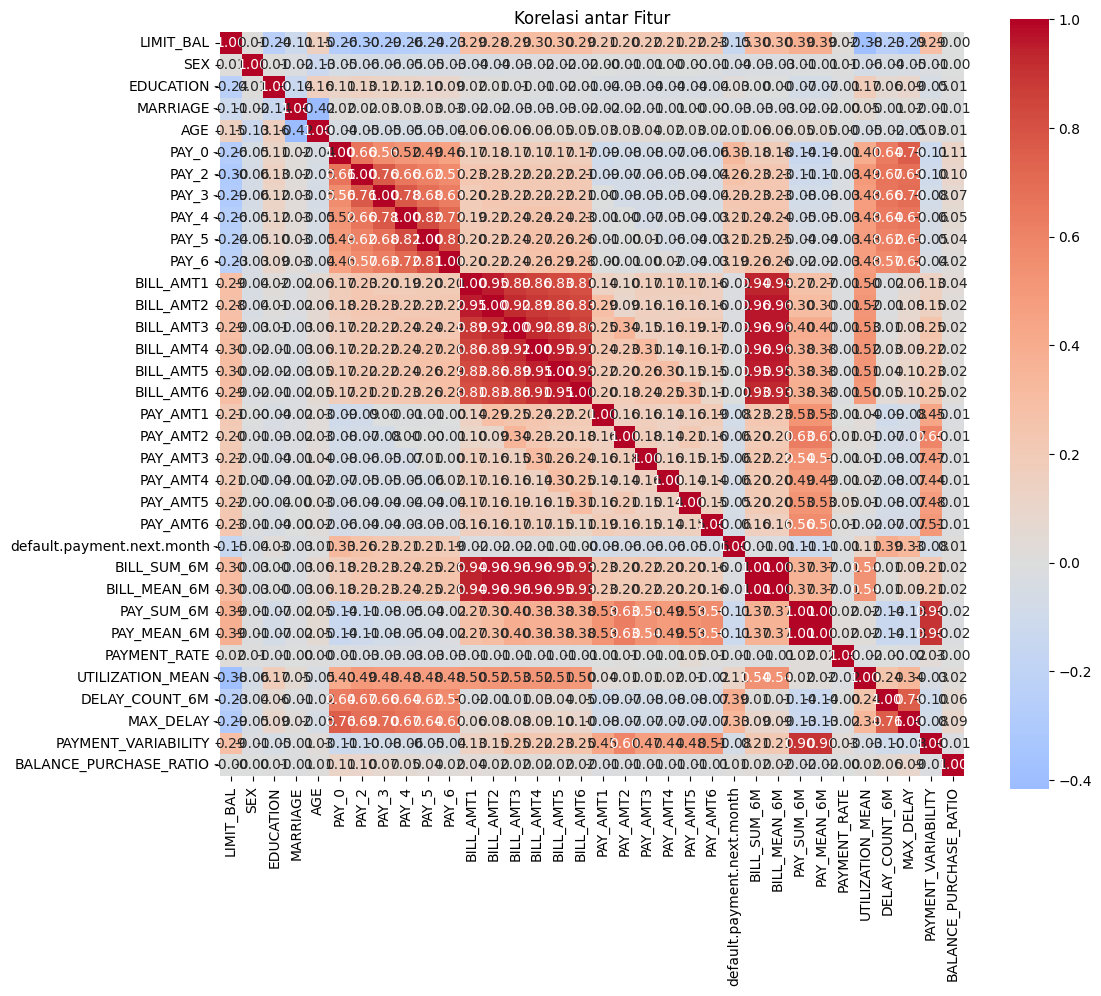

In [22]:
# Matriks korelasi untuk semua fitur numerik
plt.figure(figsize=(12,10))
corr = num_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
plt.title('Korelasi antar Fitur')
plt.show()

## 6b) Distribusi Fitur Penting per Klaster

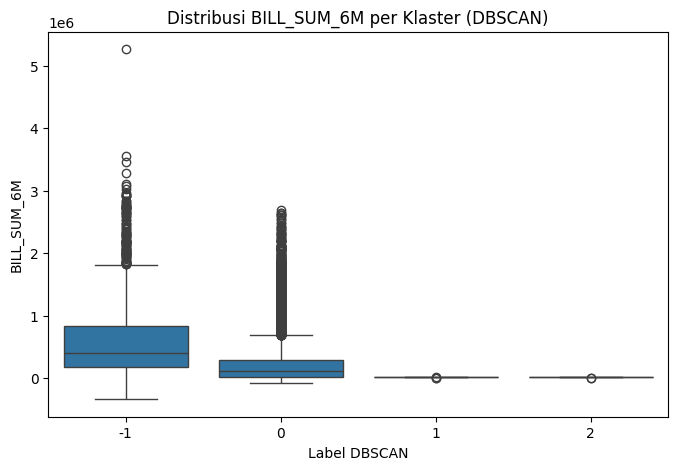

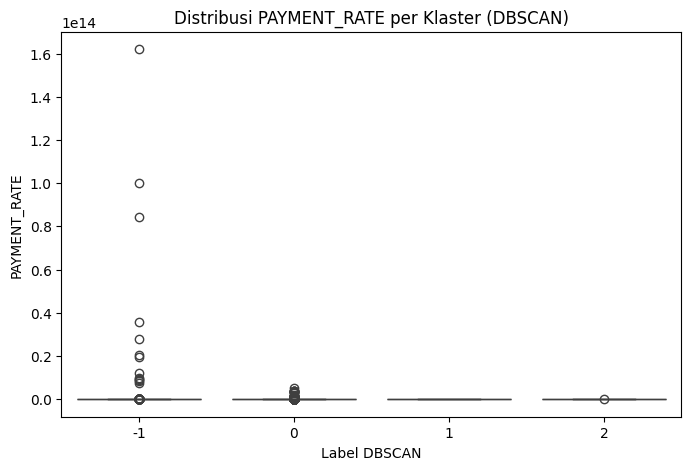

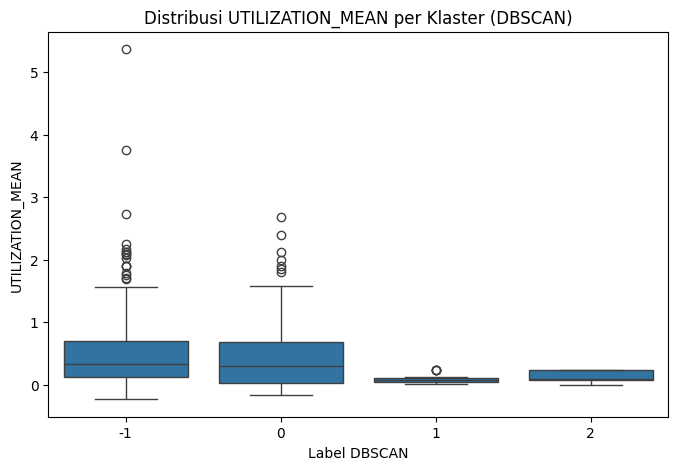

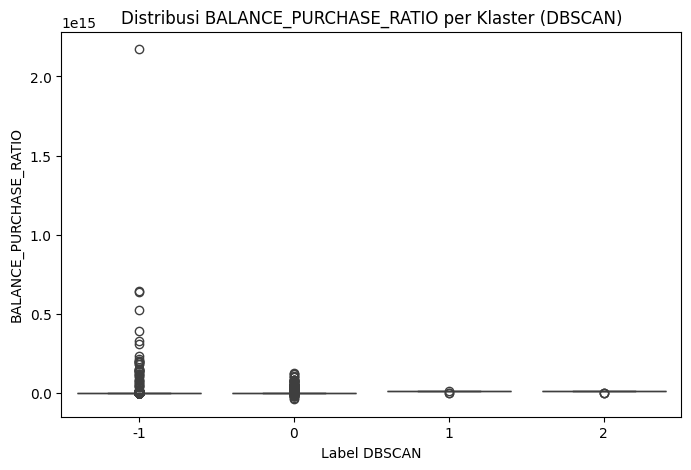

In [16]:

# Distribusi fitur utama per klaster (gunakan DBSCAN jika valid; else KMeans)
import matplotlib.pyplot as plt
import seaborn as sns

use_dbscan = (best_dbscan is not None and len(set(best_dbscan['labels'])) > 1)
labels_km = best_kmeans['labels']
labels_dbscan = best_dbscan['labels'] if use_dbscan else None

# Pilih fitur dari UCI dataset untuk visualisasi per klaster
features_to_plot = ['BILL_SUM_6M', 'PAYMENT_RATE', 'UTILIZATION_MEAN', 'BALANCE_PURCHASE_RATIO']
for feat in features_to_plot:
    if feat not in num_df.columns:
        continue
    plt.figure(figsize=(8,5))
    if use_dbscan:
        sns.boxplot(x=labels_dbscan, y=num_df[feat])
        plt.title(f'Distribusi {feat} per Klaster (DBSCAN)')
        plt.xlabel('Label DBSCAN')
    else:
        sns.boxplot(x=labels_km, y=num_df[feat])
        plt.title(f'Distribusi {feat} per Klaster (KMeans)')
        plt.xlabel('Label KMeans')
    plt.ylabel(feat)
    plt.show()


## 6c) Distribusi Jumlah Anggota per Klaster

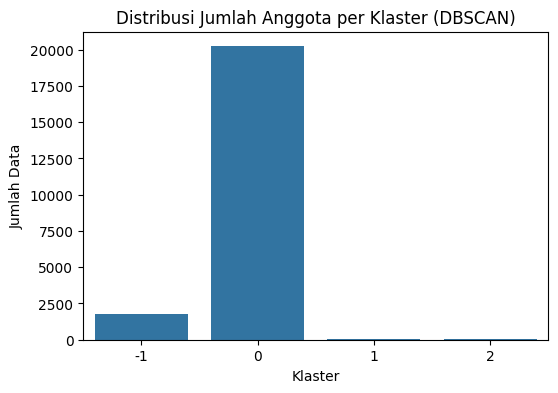

In [17]:
# Bar chart untuk jumlah anggota per klaster
import matplotlib.pyplot as plt
import seaborn as sns

use_dbscan = (best_dbscan is not None and len(set(best_dbscan['labels'])) > 1)
if use_dbscan:
    labels = best_dbscan['labels']
    model_name = 'DBSCAN'
else:
    labels = best_kmeans['labels']
    model_name = 'KMeans'

counts = pd.Series(labels).value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index.astype(str), y=counts.values)
plt.title(f'Distribusi Jumlah Anggota per Klaster ({model_name})')
plt.xlabel('Klaster')
plt.ylabel('Jumlah Data')
plt.show()


## 6d) Silhouette Plot untuk KMeans

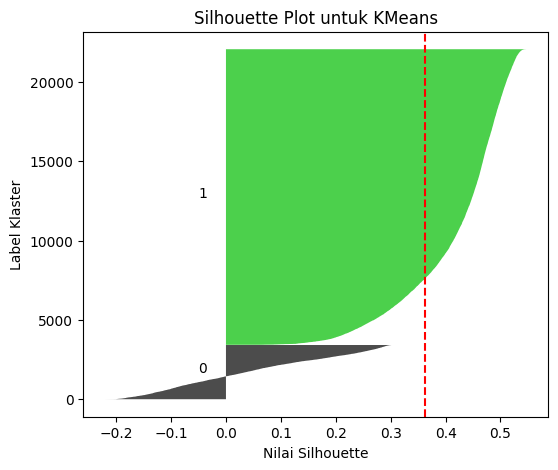

In [18]:
# Plot silhouette untuk KMeans
import matplotlib.cm as cm

km_labels = best_kmeans['labels']
sil_vals = silhouette_samples(X, km_labels)
unique_labels = np.unique(km_labels)

plt.figure(figsize=(6,5))
y_lower = 10
for i in unique_labels:
    ith_sil_vals = sil_vals[km_labels == i]
    ith_sil_vals.sort()
    size = len(ith_sil_vals)
    y_upper = y_lower + size
    color = cm.nipy_spectral(float(i) / len(unique_labels))
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_vals, facecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5*size, str(i))
    y_lower = y_upper + 10

plt.title('Silhouette Plot untuk KMeans')
plt.xlabel('Nilai Silhouette')
plt.ylabel('Label Klaster')
plt.axvline(x=best_kmeans['silhouette'], color='red', linestyle='--')
plt.show()


## 7) Approximate Nearest Neighbor (ANN)

In [19]:
# Pilih model untuk ANN: DBSCAN jika valid, else KMeans
use_dbscan_ann = (best_dbscan is not None and len(set(best_dbscan['labels'])) > 1)
labels_km = best_kmeans['labels']
labels_db = best_dbscan['labels'] if use_dbscan_ann else None

# Pilih query index dari cluster mayor
import numpy as np
rng = np.random.default_rng(42)
if use_dbscan_ann:
    from collections import Counter
    ctr = Counter([l for l in labels_db if l != -1])
    if len(ctr) > 0:
        main_label = ctr.most_common(1)[0][0]
        base_idx = np.where(labels_db == main_label)[0]
    else:
        base_idx = np.arange(X.shape[0])
else:
    base_idx = np.arange(X.shape[0])

q_count = min(5, len(base_idx))
query_idx = rng.choice(base_idx, size=q_count, replace=False).tolist()
print('Query indices:', query_idx)

results = []
if _ANNOY_OK:
    dim = X.shape[1]
    ann = AnnoyIndex(dim, 'euclidean')
    for i in range(X.shape[0]): ann.add_item(i, X[i].tolist())
    ann.build(10)
    K = 6
    for qi in query_idx:
        neigh_ids, neigh_dist = ann.get_nns_by_item(qi, K, include_distances=True)
        if neigh_ids and neigh_ids[0] == qi:
            neigh_ids = neigh_ids[1:]; neigh_dist = neigh_dist[1:]
        neigh_ids = neigh_ids[:5]; neigh_dist = neigh_dist[:5]
        for n, d in zip(neigh_ids, neigh_dist):
            results.append({
                'query_index': qi,
                'neighbor_index': int(n),
                'distance': float(d),
                'label_dbscan_query': (labels_db[qi] if use_dbscan_ann else None),
                'label_dbscan_neighbor': (labels_db[n] if use_dbscan_ann else None),
                'label_kmeans_query': labels_km[qi],
                'label_kmeans_neighbor': labels_km[n],
            })
else:
    nn = NearestNeighbors(n_neighbors=6, metric='euclidean')
    nn.fit(X)
    for qi in query_idx:
        dist, neigh = nn.kneighbors([X[qi]], n_neighbors=6)
        neigh_ids = neigh[0][1:6]; neigh_dist = dist[0][1:6]
        for n, d in zip(neigh_ids, neigh_dist):
            results.append({
                'query_index': qi,
                'neighbor_index': int(n),
                'distance': float(d),
                'label_dbscan_query': (labels_db[qi] if use_dbscan_ann else None),
                'label_dbscan_neighbor': (labels_db[n] if use_dbscan_ann else None),
                'label_kmeans_query': labels_km[qi],
                'label_kmeans_neighbor': labels_km[n],
            })
ann_df = pd.DataFrame(results)
display(ann_df.head(20))


Query indices: [17085, 9697, 14466, 1985, 9574]


,query_index,neighbor_index,distance,label_dbscan_query,label_dbscan_neighbor,label_kmeans_query,label_kmeans_neighbor
0,17085,1101,0.845119,0,0,1,1
1,17085,10506,1.876981,0,0,1,1
2,17085,17909,2.107508,0,0,1,1
3,17085,17139,2.131797,0,0,1,1
4,17085,17017,2.182205,0,0,1,1
5,9697,2158,0.605717,0,0,1,1
6,9697,14715,0.611035,0,0,1,1
7,9697,15977,0.656058,0,0,1,1
8,9697,15241,0.657681,0,0,1,1
9,9697,6265,0.725277,0,0,1,1


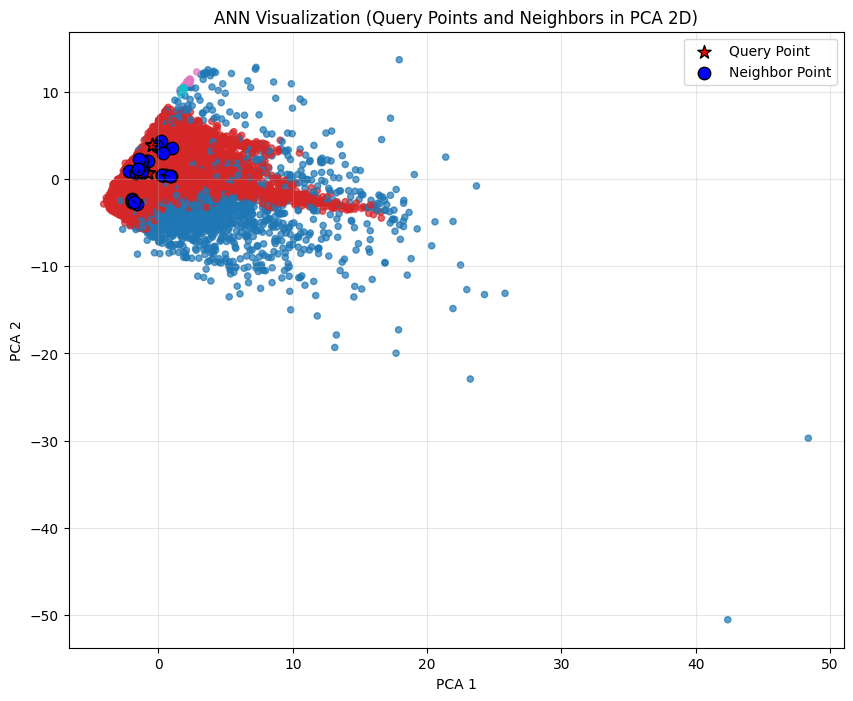

In [25]:
# Visualisasi hasil ANN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Ensure X_pca is available (run PCA if not already done)
try:
    X_pca
except NameError:
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))

# Plot all points first (optional, for context)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=10, alpha=0.3, label='All Data')

# Use DBSCAN labels if available and valid, otherwise use KMeans labels
use_dbscan_ann_viz = (best_dbscan is not None and len(set(best_dbscan['labels'])) > 1)
labels_to_use = best_dbscan['labels'] if use_dbscan_ann_viz else best_kmeans['labels']
label_name = 'DBSCAN Label' if use_dbscan_ann_viz else 'KMeans Label'

# Plot points colored by cluster
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_to_use, cmap='tab10', s=20, alpha=0.7)

# Plot query points and their neighbors
for i, row in ann_df.iterrows():
    query_idx = row['query_index']
    neighbor_idx = row['neighbor_index']

    # Draw line between query and neighbor
    plt.plot([X_pca[query_idx, 0], X_pca[neighbor_idx, 0]],
             [X_pca[query_idx, 1], X_pca[neighbor_idx, 1]],
             'k-', linewidth=0.5, alpha=0.5)

    # Highlight query point
    plt.scatter(X_pca[query_idx, 0], X_pca[query_idx, 1], c='red', s=100, edgecolors='black', marker='*', label='Query Point' if i == 0 else "")

    # Highlight neighbor point
    plt.scatter(X_pca[neighbor_idx, 0], X_pca[neighbor_idx, 1], c='blue', s=80, edgecolors='black', marker='o', label='Neighbor Point' if i == 0 else "")


plt.title('ANN Visualization (Query Points and Neighbors in PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8) Analisis Kualitatif & Ringkasan Kode

In [20]:

# Metrik & ringkasan cluster (pilih model terbaik berdasarkan Silhouette & DBI)
import numpy as np, pandas as pd

use_dbscan_analysis = (best_dbscan is not None and len(set(best_dbscan['labels'])) > 1)
sil_km = best_kmeans['silhouette']; dbi_km = best_kmeans['dbi']
if use_dbscan_analysis:
    sil_db = best_dbscan['silhouette']; dbi_db = best_dbscan['dbi']
    chosen_model = 'DBSCAN' if (sil_db > sil_km + 1e-6 or (abs(sil_db - sil_km) <= 1e-6 and dbi_db < dbi_km)) else 'KMeans'
else:
    sil_db = None; dbi_db = None; chosen_model = 'KMeans'

print('Model terbaik berdasarkan metrik:', chosen_model)
print('Nilai metrik:')
print(f'KMeans -> k={best_kmeans["k"]}, Silhouette={sil_km:.4f}, DBI={dbi_km:.4f}')
if sil_db is not None:
    print(f'DBSCAN -> eps={best_dbscan["eps"]}, ms={best_dbscan["min_samples"]}, Silhouette={sil_db:.4f}, DBI={dbi_db:.4f}')
else:
    print('DBSCAN tidak memiliki konfigurasi valid atau hanya menghasilkan satu klaster selain noise.')

# Profil klaster berdasarkan median fitur penting (disesuaikan dengan UCI dataset)
def describe_cluster(labels, name):
    import numpy as np
    s = pd.Series(labels, name='cluster')
    dfc = pd.concat([s, num_df.reset_index(drop=True)], axis=1)
    # Fitur yang akan dianalisis
    keys = [c for c in [
        'LIMIT_BAL','AGE','BILL_SUM_6M','PAY_SUM_6M','PAYMENT_RATE','UTILIZATION_MEAN',
        'DELAY_COUNT_6M','PAYMENT_VARIABILITY','BALANCE_PURCHASE_RATIO'
    ] if c in dfc.columns]
    print(f"{name}:")
    for c in sorted(dfc['cluster'].unique()):
        if name.startswith('DBSCAN') and c == -1:
            print('  -1 (noise): outlier/noise, diabaikan dalam segmentasi.')
            continue
        sub = dfc[dfc['cluster'] == c]
        med = sub[keys].median().to_dict()
        n = len(sub)
        tag = []
        if 'PAYMENT_RATE' in med and med['PAYMENT_RATE'] >= 0.5: tag.append('pembayaran tinggi')
        if 'UTILIZATION_MEAN' in med and med['UTILIZATION_MEAN'] >= 0.5: tag.append('utilisasi tinggi')
        if 'BILL_SUM_6M' in med and med['BILL_SUM_6M'] >= num_df['BILL_SUM_6M'].median()*1.2: tag.append('tagihan tinggi')
        if 'LIMIT_BAL' in med and med['LIMIT_BAL'] >= num_df['LIMIT_BAL'].median()*1.2: tag.append('limit besar')
        tag_str = ', '.join(tag) if tag else 'umum'
        print(f"  Klaster {c} (n={n}): {tag_str}")
        for k in keys:
            print(f"    - {k}: {med[k]:.3f}")

# Profil KMeans
describe_cluster(best_kmeans['labels'], f"KMeans (k={best_kmeans['k']})")
# Profil DBSCAN jika valid
if use_dbscan_analysis:
    describe_cluster(best_dbscan['labels'], f"DBSCAN (eps={best_dbscan['eps']}, ms={best_dbscan['min_samples']})")

# Evaluasi koherensi ANN
if 'ann_df' in globals() and not ann_df.empty:
    # Konsistensi KMeans
    ann_df['same_km'] = ann_df['label_kmeans_neighbor'] == ann_df['label_kmeans_query']
    coh_km = ann_df.groupby('query_index')['same_km'].mean().mean()
    print(f"Konsistensi ANN KMeans: {100.0*coh_km:.2f}%")
    if use_dbscan_analysis:
        ann_df['same_db'] = ann_df['label_dbscan_neighbor'] == ann_df['label_dbscan_query']
        coh_db = ann_df.groupby('query_index')['same_db'].mean().mean()
        print(f"Konsistensi ANN DBSCAN: {100.0*coh_db:.2f}%")


Model terbaik berdasarkan metrik: DBSCAN
Nilai metrik:
KMeans -> k=2, Silhouette=0.3634, DBI=1.5826
DBSCAN -> eps=3.0, ms=10, Silhouette=0.4203, DBI=1.7236
KMeans (k=2):
  Klaster 0 (n=3416): utilisasi tinggi, tagihan tinggi, limit besar
    - LIMIT_BAL: 230000.000
    - AGE: 35.000
    - BILL_SUM_6M: 831284.500
    - PAY_SUM_6M: 43247.000
    - PAYMENT_RATE: 0.042
    - UTILIZATION_MEAN: 0.720
    - DELAY_COUNT_6M: 0.000
    - PAYMENT_VARIABILITY: 3144.721
    - BALANCE_PURCHASE_RATIO: 24.009
  Klaster 1 (n=18625): umum
    - LIMIT_BAL: 100000.000
    - AGE: 33.000
    - BILL_SUM_6M: 94370.000
    - PAY_SUM_6M: 10926.000
    - PAYMENT_RATE: 0.106
    - UTILIZATION_MEAN: 0.182
    - DELAY_COUNT_6M: 0.000
    - PAYMENT_VARIABILITY: 1206.163
    - BALANCE_PURCHASE_RATIO: 7.175
DBSCAN (eps=3.0, ms=10):
  -1 (noise): outlier/noise, diabaikan dalam segmentasi.
  Klaster 0 (n=20228): umum
    - LIMIT_BAL: 120000.000
    - AGE: 33.000
    - BILL_SUM_6M: 114405.000
    - PAY_SUM_6M: 12500.000
